# Metapath2Vec KuaiRec Recommendations

Currently the Word2Vec recommendation system only uses track play sequences to generate track embeddings, which are then used many times downstream (for example user embeddings are the average track embedding of their listening history). There is potenitally explicit graph information that the sequence data is missing, coming from user-user follows or even more complex graph structure like album and playlist nodes. One option is to continue using Word2Vec, but simply augment the sequence data being fed to it. These additional sequences can be generated by the Metapath2Vec sampling algorithm which uses the heterogeneous graph to generate specific types of sequences (for example track-user-user-track represents tracks listened by users who follow each other, or track-album-track would be tracks in the same album). These could be supplemental to the existing track sequences, so that nodes associated together often in the graph are closer together in vector space ([Metapath2Vec](https://ericdongyx.github.io/papers/KDD17-dong-chawla-swami-metapath2vec.pdf))

This notebook aims to explore Metapath2Vec as a means of improving streaming service recommendation performance (non-personalized & personalized). We experiment on the open source video streaming recommendation dataset [KuaiRec](https://kuairec.com/) because it has very similar structure to SoundCloud's data (sequential streams with a social network), as well as a fully observed test set which allows us to rely on offline evaluation results.

## Imports & Data Processing <a class="anchor" id="imports"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
from tqdm import tqdm
from typing import Dict, List, Optional, Tuple
from collections import defaultdict
import pickle
import random
import itertools
import copy
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from gensim.models.word2vec import Word2Vec
from scipy.stats import wilcoxon
import warnings
import logging
warnings.simplefilter(action="ignore", category=FutureWarning)
import os

import torch
from torch_geometric.nn.models import MetaPath2Vec
from torch_geometric.nn import MetaPath2Vec
from torch_geometric.data import HeteroData
from torch import nn, Tensor
from torch.utils.data import DataLoader
from torch_geometric.index import index2ptr
from torch_geometric.typing import EdgeType, NodeType, OptTensor
from torch_geometric.utils import sort_edge_index

In [11]:
# Load KuaiRec user watch histories, filter for only positive interactions (watch_ratio >= 2, as mentioned by the authors),
# and create chronological watch sequences for each user (for W2V)
train = pd.read_csv('KuaiRec/big_matrix.csv')
train = train[train['watch_ratio'] >= 2]
train_sequences = train.sort_values(['user_id', 'time'], ascending=[True, True]).groupby('user_id')['video_id'].apply(list).reset_index()
train_sequences.to_parquet('KuaiRec/train_sequences.parquet')

In [20]:
# Take fully observed test set positive interactions & create val and test pairs for non-personalized recommendation
# as done in Deezer's W2V Hyperparams matter paper (https://github.com/deezer/w2v_reco_hyperparameters_matter/blob/master/src/main.py)
test = pd.read_csv('KuaiRec/small_matrix.csv')
test = test[test['watch_ratio'] >= 2].sort_values(['user_id', 'time']).reset_index(drop=True)
pairs = test.groupby('user_id')['video_id'].apply(lambda x: list(zip(x[:-1], x[1:]))).explode().tolist()
np.random.shuffle(pairs)
split_idx = int(len(pairs) * 0.8)
test_pairs = pairs[:split_idx]
val_pairs = pairs[split_idx:]
np.save('KuaiRec/val_pairs.npy', np.array(val_pairs, dtype=int))
np.save('KuaiRec/test_pairs.npy', np.array(test_pairs, dtype=int))

In [15]:
# Best W2V video/track embeddings config will be used as initialization for Metapath2vec
train = pd.read_parquet('KuaiRec/train_sequences.parquet')
sequences = train['video_id'].apply(lambda x: list(map(str, x))).tolist()
val = np.load('KuaiRec/val_pairs.npy')
model = Word2Vec(
            vector_size=50,
            window=15,
            workers=multiprocessing.cpu_count(),
            sg=1,
            min_count=1,
            compute_loss=True,
        )
model.build_vocab(sequences)
model.train(
            corpus_iterable=sequences,
            total_examples=len(sequences),
            epochs=75,
        )

(70180942, 70242600)

In [16]:
df_watch = pd.read_csv('KuaiRec/big_matrix.csv')

unique_users = df_watch['user_id'].unique()
unique_videos = df_watch['video_id'].unique()

df_watch = df_watch[df_watch['watch_ratio'] >= 2].sort_values(['user_id', 'time'])

user2idx = {uid: i for i, uid in enumerate(unique_users)}
video2idx = {vid: i for i, vid in enumerate(unique_videos)}
idx2video = {i: vid for vid, i in video2idx.items()}


# Build user->video edge index
user_col = df_watch['user_id'].map(user2idx).values
video_col = df_watch['video_id'].map(video2idx).values
edge_index_uv = np.vstack([user_col, video_col])

df_social = pd.read_csv('KuaiRec/social_network.csv')
df_social['friend_list'] = df_social['friend_list'].apply(lambda x: x.strip('[]').split(','))
df_social = df_social.explode('friend_list').dropna()
df_social['friend_list'] = df_social['friend_list'].astype(int)

# Build user-user edge index
userA = df_social['user_id'].map(user2idx).values
userB = df_social['friend_list'].map(user2idx).values

edge_index_uu = np.vstack([userA, userB])

In [17]:
data = HeteroData()
# Add user, video node counts
data['user'].num_nodes = len(user2idx)
data['video'].num_nodes = len(video2idx)
# user->video edges
data['user', 'watches', 'video'].edge_index = torch.tensor(edge_index_uv, dtype=torch.long)
# Include reverse edges too:
data['video', 'watched_by', 'user'].edge_index = torch.tensor(np.flip(edge_index_uv, axis=0).copy(order='C'), dtype=torch.long)
data['user', 'follows', 'user'].edge_index = torch.tensor(edge_index_uu, dtype=torch.long)
w2v_dim = model.vector_size

In [18]:
# Create a zero tensor for all video embeddings & update them with W2V trained ones
model_vocab = list(model.wv.index_to_key)
video_emb = np.zeros((len(video2idx), w2v_dim), dtype=np.float32)
for vid, idx in video2idx.items():
    if str(vid) in model_vocab:
        video_emb[idx] = model.wv[str(vid)]

# Set data video embeddings to the W2V embeddings
data['video'].x = torch.tensor(video_emb, dtype=torch.float32)

num_users = len(user2idx)

user_to_videos = defaultdict(list)
for _, row in df_watch.iterrows():
    user_id = row['user_id']
    video_id_str = str(row['video_id'])  # Convert to string for Word2Vec keys
    user_to_videos[user_id].append(video_id_str)

# Initialize user embeddings to their average video embeddings from training watch history
user_emb = torch.zeros((num_users, w2v_dim), dtype=torch.float32)
for uid, u_idx in user2idx.items():
    vids_watched = user_to_videos[uid]
    if not vids_watched:
        continue  # user_emb remains zero if no videos

    sum_vec = np.zeros(w2v_dim, dtype=np.float32)
    count = 0
    for vid_str in vids_watched:
        if vid_str in model.wv:  # If the video ID is in the W2V vocab
            sum_vec += model.wv[vid_str]
            count += 1
    if count > 0:
        user_emb[u_idx] = torch.tensor(sum_vec / count, dtype=torch.float32)

# Set data user embeddings to the user's average W2V video embeddings
data['user'].x = user_emb

In [19]:
# Two potential metapath options
meta_path_uv = [
    ('user', 'watches', 'video'),
    ('video', 'watched_by', 'user')
]

meta_path_uuv = [
    ('user', 'follows', 'user'),
    ('user', 'watches', 'video'),
    ('video', 'watched_by', 'user')
]
chosen_meta_path = meta_path_uv

## User embeddings

In [11]:
train = pd.read_parquet('KuaiRec/train_sequences.parquet')
sequences = train['video_id'].apply(lambda x: list(map(str, x))).tolist()
val = np.load('KuaiRec/val_pairs.npy')
model = Word2Vec(
            vector_size=50,
            window=15,
            workers=multiprocessing.cpu_count(),
            sg=1,
            min_count=1,
            compute_loss=True,
        )
model.build_vocab(sequences)
model.train(
            corpus_iterable=sequences,
            total_examples=len(sequences),
            epochs=75,
        )

(70180638, 70242600)

In [12]:
df = pd.read_csv('KuaiRec/small_matrix.csv')
df = df[df['watch_ratio'] >= 2].sort_values(['user_id', 'time']).reset_index(drop=True)

val_data = {}
test_data = {}

for user_id, group in df.groupby('user_id'):
    videos = group['video_id'].tolist()
    random.shuffle(videos)
    split_idx = int(len(videos) * 0.2)  # 20% val, 80% test
    val_videos = videos[:split_idx]
    tst_videos = videos[split_idx:]

    val_data[user_id] = set(val_videos)
    test_data[user_id] = set(tst_videos)
    
with open('KuaiRec/val_data.pkl', 'wb') as f:
    pickle.dump(val_data, f)
with open('KuaiRec/test_data.pkl', 'wb') as f:
    pickle.dump(test_data, f)

In [10]:
with open('KuaiRec/val_data.pkl', 'rb') as f:
    val_data = pickle.load(f)
with open('KuaiRec/test_data.pkl', 'rb') as f:
    test_data = pickle.load(f)

In [11]:
def evaluate_user_reco(
    user_emb,       # shape [num_users, dim]
    video_emb,      # shape [num_videos, dim]
    val_data,       # dict: user_id -> set of val videos
    test_data,      # dict: user_id -> set of test videos
    user2idx, 
    video2idx,
    idx2video,
    is_validation=True,
    top_k=100,
    return_per_user=False,  # <-- NEW: if True, we return lists of HRs & NDCGs
    progress_bar=True
):
    """
    If is_validation=True, we evaluate performance on val_data (user-> val videos).
    If is_validation=False, we evaluate performance on test_data (user-> test videos).
    We'll ignore any correct predictions that belong in the *other* set (val vs test).

    Returns:
      A dict containing overall HR@k and nDCG@k averages.
      If return_per_user=True, also returns (hr_list, ndcg_list) for significance testing.
    """
    neigh = NearestNeighbors(n_neighbors=top_k*2, metric='euclidean')
    neigh.fit(video_emb)
    
    idcg_cache = {}
    def get_idcg(r_size):
        cut = min(top_k, r_size)
        if cut not in idcg_cache:
            # compute sum of 1/log2(i+2) for i in [0 .. cut-1]
            val = 0.0
            for i in range(cut):
                val += 1.0 / np.log2(i + 2)
            idcg_cache[cut] = val
        return idcg_cache[cut]
    
    total_hr = 0.0
    total_ndcg = 0.0
    user_count = 0

    # For significance testing:
    hr_list = []
    ndcg_list = []
    
    relevant_dict = val_data if is_validation else test_data
    other_dict    = test_data if is_validation else val_data
    
    for user_id in (tqdm(relevant_dict.keys()) if progress_bar else relevant_dict.keys()):
        if user_id not in user2idx:
            continue
        u_idx = user2idx[user_id]
        relevant_set = relevant_dict[user_id]   # target set
        other_set    = other_dict.get(user_id, set())  # might be empty or missing
        if len(relevant_set) == 0:
            continue
        
        user_vec = user_emb[u_idx].reshape(1, -1)
        distances, indices = neigh.kneighbors(user_vec, n_neighbors=top_k*2)
        indices = indices.flatten()

        ranked_items = []
        for idx in indices:
            vid = idx2video[idx]
            # Skip items that belong to the "other" set
            if vid in other_set:
                continue
            ranked_items.append(vid)
            if len(ranked_items) == top_k:
                break

        # Identify which positions hit a relevant video
        hits_positions = []
        for rank, vid in enumerate(ranked_items):
            if vid in relevant_set:
                hits_positions.append(rank)

        hits_count = len(hits_positions)
        hr_k = hits_count / float(min(top_k, len(relevant_set)))
        
        dcg_val = 0.0
        for pos in hits_positions:
            dcg_val += 1.0 / np.log2(pos + 2)

        idcg_val = get_idcg(len(relevant_set))
        ndcg_k = (dcg_val / idcg_val) if idcg_val > 0 else 0.0
        
        total_hr += hr_k
        total_ndcg += ndcg_k
        user_count += 1

        # Collect per-user metrics
        hr_list.append(hr_k)
        ndcg_list.append(ndcg_k)
    
    if user_count == 0:
        # Return 0's if no users found
        base_result = {f'HR@{top_k}': 0.0, f'nDCG@{top_k}': 0.0}
        return (base_result, ([], [])) if return_per_user else base_result

    hr_avg = total_hr / user_count
    ndcg_avg = total_ndcg / user_count

    result_dict = {f'HR@{top_k}': hr_avg, f'nDCG@{top_k}': ndcg_avg}
    
    if return_per_user:
        return result_dict, (hr_list, ndcg_list)
    else:
        return result_dict

In [32]:
WALK_LENGTHS = [2, 4, 6, 10]
CONTEXT_SIZES = [2, 3, 6]
WALKS_PER_NODE = [1, 2, 5]
NUM_NEG_SAMPLES = [3, 5, 8]
LEARNING_RATES = [0.01]

MAX_EPOCHS = 16
PATIENCE = 3  # Early stopping patience

def run_metapath2vec_experiment(
    data,  # HeteroData
    evaluate_user_reco,  # your evaluation function
    user2idx, video2idx, idx2video, val_data, test_data,
    walk_length, context_size, walks_per_node, num_negative_samples,
    lr, w2v_dim
):
    """Train MetaPath2Vec with given hyperparams, return best HR@100."""
    from torch_geometric.nn.models import MetaPath2Vec
    
    try:
        # 1) Build MetaPath2Vec model with these hyperparams
        model_metapath = MetaPath2Vec(
            data.edge_index_dict,
            embedding_dim=w2v_dim,
            metapath=meta_path_uuv,
            walk_length=walk_length,
            context_size=context_size,
            walks_per_node=walks_per_node,
            num_negative_samples=num_negative_samples,
            sparse=True
        ).to('cuda')
    except:
        return None

    with torch.no_grad():
        # Copy in user & video inits:
        model_metapath('video').data.copy_(data['video'].x.to('cuda'))
        model_metapath('user').data.copy_(data['user'].x.to('cuda'))

    loader = model_metapath.loader(batch_size=128, shuffle=True, num_workers=4)
    optimizer = torch.optim.SparseAdam(model_metapath.parameters(), lr=lr)

    best_hr = 0.0
    epochs_no_improve = 0

    def train_one_epoch():
        model_metapath.train()
        total_loss = 0
        for pos_rw, neg_rw in loader:
            pos_rw, neg_rw = pos_rw.to('cuda'), neg_rw.to('cuda')
            optimizer.zero_grad()
            loss = model_metapath.loss(pos_rw, neg_rw)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        return total_loss

    best_hr_so_far = 0.0

    for epoch in range(1, MAX_EPOCHS + 1):
        loss_val = train_one_epoch()

        # Evaluate on validation:
        model_metapath.eval()
        with torch.no_grad():
            user_emb = model_metapath('user').cpu().detach().numpy()
            video_emb = model_metapath('video').cpu().detach().numpy()
        
        val_metrics = evaluate_user_reco(
            user_emb=user_emb,
            video_emb=video_emb,
            val_data=val_data,
            test_data=test_data,
            user2idx=user2idx,
            video2idx=video2idx,
            idx2video=idx2video,
            is_validation=True,
            top_k=100,
            progress_bar=False
        )
        hr100 = val_metrics.get('HR@100', 0.0)

        # Early stopping check:
        if hr100 > best_hr_so_far:
            best_hr_so_far = hr100
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= PATIENCE:
            break

    return best_hr_so_far

search_results = []
best_hr_overall = 0.0
best_config = None

for wl, cs, wpn, neg, learning_rate in itertools.product(
    WALK_LENGTHS,
    CONTEXT_SIZES,
    WALKS_PER_NODE,
    NUM_NEG_SAMPLES,
    LEARNING_RATES
):
    
    hr100 = run_metapath2vec_experiment(
        data=data,
        evaluate_user_reco=evaluate_user_reco,
        user2idx=user2idx,
        video2idx=video2idx,
        idx2video=idx2video,
        val_data=val_data,
        test_data=test_data,
        walk_length=wl,
        context_size=cs,
        walks_per_node=wpn,
        num_negative_samples=neg,
        lr=learning_rate,
        w2v_dim=w2v_dim
    )
    
    config = {
        'walk_length': wl,
        'context_size': cs,
        'walks_per_node': wpn,
        'num_negative_samples': neg,
        'lr': learning_rate
    }
    search_results.append((config, hr100))

    if ((hr100 is not None) and (hr100 > best_hr_overall)):
        best_hr_overall = hr100
        best_config = copy.deepcopy(config)

print("\n==============================")
print("Search complete!")
print("Best HR@100:", best_hr_overall)
print("Best config:", best_config)
print("==============================\n")


Search complete!
Best HR@100: 0.24464117417663778
Best config: {'walk_length': 6, 'context_size': 6, 'walks_per_node': 2, 'num_negative_samples': 8, 'lr': 0.01}



## W2V Average User Embeddings

In [33]:
# Evaluate W2V user embeddings
df_train = pd.read_csv('KuaiRec/big_matrix.csv')
df_train = df_train[df_train['watch_ratio'] >= 2].sort_values(['user_id', 'time'])

# 2) Build user->list_of_videos mapping from TRAIN
user_to_videos = defaultdict(list)
for _, row in df_train.iterrows():
    user_id = row['user_id']
    video_id = str(row['video_id'])  # Convert to string for Word2Vec keys
    user_to_videos[user_id].append(video_id)
    
w2v_dim = model.vector_size

unique_users = sorted(user_to_videos.keys())
user2idx = {uid: i for i, uid in enumerate(unique_users)}
num_users = len(unique_users)

# Initialize user_emb array
user_emb = np.zeros((num_users, w2v_dim), dtype=np.float32)

for uid, idx in user2idx.items():
    videos_list = user_to_videos[uid]
    if not videos_list:
        # No videos => user embedding remains zero
        continue
        
    sum_vec = np.zeros(w2v_dim, dtype=np.float32)
    count = 0
    for vid in videos_list:
        if vid in model.wv:  # If the video ID is in the W2V vocab
            sum_vec += model.wv[vid]
            count += 1
    if count > 0:
        user_emb[idx] = sum_vec / count 
        
video_emb = np.zeros((len(video2idx), w2v_dim), dtype=np.float32)
for vid, v_idx in video2idx.items():
    vid_str = str(vid)  # In case original IDs are int
    if vid_str in model.wv:
        video_emb[v_idx] = model.wv[vid_str]
    
val_metrics = evaluate_user_reco(
    user_emb=user_emb,
    video_emb=video_emb,
    val_data=val_data,
    test_data=test_data,    # so we ignore test items if they appear
    user2idx=user2idx,
    video2idx=video2idx,
    idx2video=idx2video,    # e.g., {0: 'vid_a', 1: 'vid_b', ...}
    is_validation=True,
    top_k=100
)
print("Val metrics:", val_metrics)

100%|██████████| 1411/1411 [00:01<00:00, 875.44it/s]

Val metrics: {'HR@100': 0.1370908602060868, 'nDCG@100': 0.05150164883402525}


## Metapath2Vec User Embeddings vs Average Video Embedding Test performance

In [12]:
with open('KuaiRec/val_data.pkl', 'rb') as f:
    val_data = pickle.load(f)
with open('KuaiRec/test_data.pkl', 'rb') as f:
    test_data = pickle.load(f)

In [14]:
# Best metapath2vec model:
model_metapath = MetaPath2Vec(
    data.edge_index_dict,
    embedding_dim=50,
    metapath=meta_path_uuv,
    walk_length=10,
    context_size=3,
    walks_per_node=2,
    num_negative_samples=8,
    sparse=True
).to('cuda')

with torch.no_grad():
    model_metapath('video').data.copy_(data['video'].x.to('cuda'))
    model_metapath('user').data.copy_(data['user'].x.to('cuda'))

loader = model_metapath.loader(batch_size=128, shuffle=True, num_workers=4)
optimizer = torch.optim.SparseAdam(
    [p for p in model_metapath.parameters()],
    lr=0.01
)

def train_one_epoch():
    model_metapath.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        pos_rw, neg_rw = pos_rw.to('cuda'), neg_rw.to('cuda')
        optimizer.zero_grad()
        loss = model_metapath.loss(pos_rw, neg_rw)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss


for epoch in range(1, 5):
    epoch_loss = train_one_epoch()
    print(f"Epoch {epoch}, Loss: {epoch_loss:.4f}")

    # Evaluate on validation:
    model_metapath.eval()
    user_emb = model_metapath('user').cpu().detach().numpy()
    video_emb = model_metapath('video').cpu().detach().numpy()

    val_metrics = evaluate_user_reco(
        user_emb=user_emb,
        video_emb=video_emb,
        val_data=val_data,
        test_data=test_data,
        user2idx=user2idx,
        video2idx=video2idx,
        idx2video=idx2video,
        is_validation=True,   # i.e., we're evaluating on val_data
        top_k=100
    )
    print("Val metrics:", val_metrics)
    
user_emb_meta = model_metapath('user').cpu().detach().numpy()
video_emb_meta = model_metapath('video').cpu().detach().numpy()

Epoch 1, Loss: 83.5706


100%|██████████| 1411/1411 [00:01<00:00, 791.06it/s]

Val metrics: {'HR@100': 0.12173468096532088, 'nDCG@100': 0.051446443951429256}


Epoch 2, Loss: 38.0907


100%|██████████| 1411/1411 [00:01<00:00, 912.40it/s] 

Val metrics: {'HR@100': 0.20284476280916797, 'nDCG@100': 0.11334560237789028}


Epoch 3, Loss: 28.7366


100%|██████████| 1411/1411 [00:01<00:00, 895.09it/s]

Val metrics: {'HR@100': 0.2250059714749066, 'nDCG@100': 0.14262771129331958}


Epoch 4, Loss: 25.8411


100%|██████████| 1411/1411 [00:01<00:00, 874.63it/s]

Val metrics: {'HR@100': 0.22633098403769514, 'nDCG@100': 0.17051102197112541}


In [16]:
# Best W2V Average embedding model:
# Evaluate W2V user embeddings
df_train = pd.read_csv('KuaiRec/big_matrix.csv')
df_train = df_train[df_train['watch_ratio'] >= 2].sort_values(['user_id', 'time'])

# Build user->list_of_videos mapping from TRAIN
user_to_videos = defaultdict(list)
for _, row in df_train.iterrows():
    user_id = row['user_id']
    video_id = str(row['video_id'])  # Convert to string for Word2Vec keys
    user_to_videos[user_id].append(video_id)

train = pd.read_parquet('KuaiRec/train_sequences.parquet')
sequences = train['video_id'].apply(lambda x: list(map(str, x))).tolist()
model = Word2Vec(
            vector_size=50,
            window=15,
            workers=multiprocessing.cpu_count(),
            sg=1,
            min_count=1,
            compute_loss=True,
        )
model.build_vocab(sequences)
model.train(
            corpus_iterable=sequences,
            total_examples=len(sequences),
            epochs=75,
        )

w2v_dim = model.vector_size

unique_users = sorted(user_to_videos.keys())
user2idx = {uid: i for i, uid in enumerate(unique_users)}
num_users = len(unique_users)

# Initialize user_emb array
user_emb = np.zeros((num_users, w2v_dim), dtype=np.float32)

for uid, idx in user2idx.items():
    videos_list = user_to_videos[uid]
    if not videos_list:
        # No videos => user embedding remains zero
        continue
        
    sum_vec = np.zeros(w2v_dim, dtype=np.float32)
    count = 0
    for vid in videos_list:
        if vid in model.wv:  # If the video ID is in the W2V vocab
            sum_vec += model.wv[vid]
            count += 1
    if count > 0:
        user_emb[idx] = sum_vec / count 
        
video_emb = np.zeros((len(video2idx), w2v_dim), dtype=np.float32)
for vid, v_idx in video2idx.items():
    vid_str = str(vid)  # In case original IDs are int
    if vid_str in model.wv:
        video_emb[v_idx] = model.wv[vid_str]
    
val_metrics = evaluate_user_reco(
    user_emb=user_emb,
    video_emb=video_emb,
    val_data=val_data,
    test_data=test_data,    # so we ignore test items if they appear
    user2idx=user2idx,
    video2idx=video2idx,
    idx2video=idx2video,    # e.g., {0: 'vid_a', 1: 'vid_b', ...}
    is_validation=True,
    top_k=100
)
print("Val metrics:", val_metrics)

user_emb_w2v = user_emb
video_emb_w2v = video_emb

100%|██████████| 1411/1411 [00:01<00:00, 987.67it/s] 

Val metrics: {'HR@100': 0.13432801181250306, 'nDCG@100': 0.05021194543639899}


In [17]:
# Run both on test set
meta_test_metrics = evaluate_user_reco(
    user_emb=user_emb_meta,
    video_emb=video_emb_meta,
    val_data=val_data,
    test_data=test_data,    # so we ignore val items if they appear
    user2idx=user2idx,
    video2idx=video2idx,
    idx2video=idx2video,    # e.g., {0: 'vid_a', 1: 'vid_b', ...}
    is_validation=False,
    top_k=100,
    return_per_user=True
)

w2v_test_metrics = evaluate_user_reco(
    user_emb=user_emb_w2v,
    video_emb=video_emb_w2v,
    val_data=val_data,
    test_data=test_data,    # so we ignore val items if they appear
    user2idx=user2idx,
    video2idx=video2idx,
    idx2video=idx2video,    # e.g., {0: 'vid_a', 1: 'vid_b', ...}
    is_validation=False,
    top_k=100,
    return_per_user=True
)

100%|██████████| 1411/1411 [00:01<00:00, 966.56it/s] 


In [18]:
print(meta_test_metrics[0])
print(w2v_test_metrics[0])

{'HR@100': 0.26084614521442995, 'nDCG@100': 0.28257371066278386}
{'HR@100': 0.1406936537851741, 'nDCG@100': 0.08665289304417413}


In [19]:
# Wilcoxon signed-rank test:
w_stat, p_value_w = wilcoxon(meta_test_metrics[1][0], w2v_test_metrics[1][0])
print("HR@100 Wilcoxon p-value:", p_value_w)
w_stat, p_value_w = wilcoxon(meta_test_metrics[1][1], w2v_test_metrics[1][1])
print("NDCG@100 Wilcoxon p-value:", p_value_w)

HR@100 Wilcoxon p-value: 4.804588422798175e-221
NDCG@100 Wilcoxon p-value: 5.1815499262241566e-232


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 17903 samples in 0.001s...
[t-SNE] Computed neighbors for 17903 samples in 0.364s...
[t-SNE] Computed conditional probabilities for sample 1000 / 17903
[t-SNE] Computed conditional probabilities for sample 2000 / 17903
[t-SNE] Computed conditional probabilities for sample 3000 / 17903
[t-SNE] Computed conditional probabilities for sample 4000 / 17903
[t-SNE] Computed conditional probabilities for sample 5000 / 17903
[t-SNE] Computed conditional probabilities for sample 6000 / 17903
[t-SNE] Computed conditional probabilities for sample 7000 / 17903
[t-SNE] Computed conditional probabilities for sample 8000 / 17903
[t-SNE] Computed conditional probabilities for sample 9000 / 17903
[t-SNE] Computed conditional probabilities for sample 10000 / 17903
[t-SNE] Computed conditional probabilities for sample 11000 / 17903
[t-SNE] Computed conditional probabilities for sample 12000 / 17903
[t-SNE] Computed conditional probabilities for sam

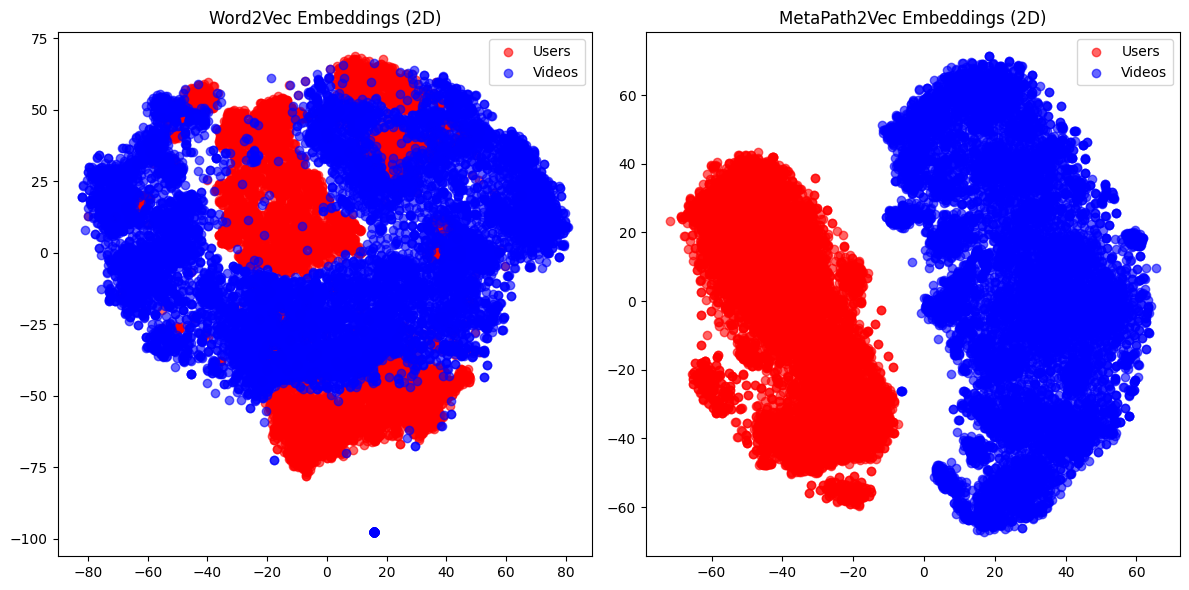

In [20]:
def visualize_embeddings_2D(user_emb_w2v, video_emb_w2v,
                           user_emb_meta, video_emb_meta,
                           method='tsne'):
    """
    Plots 2D visualizations (side-by-side) of two embedding sets:
      1) Word2Vec-based user & video embeddings
      2) MetaPath2Vec-based user & video embeddings

    method: 'tsne' or 'pca'
    """
    # -------------------------
    # 1) Prepare W2V embeddings
    # -------------------------
    # Combine user + video
    emb_w2v = np.concatenate([user_emb_w2v, video_emb_w2v], axis=0)
    labels_w2v = np.array(
        [0]*user_emb_w2v.shape[0] + [1]*video_emb_w2v.shape[0]
    )  # 0=user, 1=video

    # -------------------------
    # 2) Prepare Meta embeddings
    # -------------------------
    emb_meta = np.concatenate([user_emb_meta, video_emb_meta], axis=0)
    labels_meta = np.array(
        [0]*user_emb_meta.shape[0] + [1]*video_emb_meta.shape[0]
    )

    # -------------------------
    # 3) Dimensionality reduction
    # -------------------------
    if method.lower() == 'tsne':
        reducer1 = TSNE(n_components=2, random_state=42, verbose=1)
        reducer2 = TSNE(n_components=2, random_state=42, verbose=1)
    else:
        # method='pca'
        from sklearn.decomposition import PCA
        reducer1 = PCA(n_components=2, random_state=42)
        reducer2 = PCA(n_components=2, random_state=42)

    # Fit-transform each model's embeddings separately:
    emb_2d_w2v = reducer1.fit_transform(emb_w2v)
    emb_2d_meta = reducer2.fit_transform(emb_meta)

    # -------------------------
    # 4) Plot side-by-side
    # -------------------------
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Left subplot: W2V embeddings
    ax_w2v = axes[0]
    ax_w2v.scatter(
        emb_2d_w2v[labels_w2v==0, 0],
        emb_2d_w2v[labels_w2v==0, 1],
        color='red', alpha=0.6, label='Users'
    )
    ax_w2v.scatter(
        emb_2d_w2v[labels_w2v==1, 0],
        emb_2d_w2v[labels_w2v==1, 1],
        color='blue', alpha=0.6, label='Videos'
    )
    ax_w2v.set_title("Word2Vec Embeddings (2D)")
    ax_w2v.legend()

    # Right subplot: Meta embeddings
    ax_meta = axes[1]
    ax_meta.scatter(
        emb_2d_meta[labels_meta==0, 0],
        emb_2d_meta[labels_meta==0, 1],
        color='red', alpha=0.6, label='Users'
    )
    ax_meta.scatter(
        emb_2d_meta[labels_meta==1, 0],
        emb_2d_meta[labels_meta==1, 1],
        color='blue', alpha=0.6, label='Videos'
    )
    ax_meta.set_title("MetaPath2Vec Embeddings (2D)")
    ax_meta.legend()

    plt.tight_layout()
    plt.show()


visualize_embeddings_2D(
    user_emb_w2v, video_emb_w2v,
    user_emb_meta, video_emb_meta,
    method='tsne'  # or 'pca'
)

This reduced dimension visualization does not let us conclude much, but we can see a clear difference when using average video embeddings for each user vs trained metapath2vec embeddings. The metapath2vec algorithm (on a bipartite graph in this case) clearly learns the distinction between user and video nodes. And despite them looking like very separated clusters (which might be worrying when using KNN to recommend videos), I assume that there are many more details in the hidden dimensions which allow the recommendation performance to be so much better than the former model.

## Update

In [2]:
EMBEDDING_DIM = 50
METAPATH = [
    ('user', 'follows', 'user'),
    ('user', 'watches', 'video'),
    ('video', 'watched_by', 'user')
]

In [3]:
def w2v_emb():
    df_watch = pd.read_csv('KuaiRec/big_matrix.csv')
    df_watch = df_watch[df_watch['watch_ratio'] >= 2].sort_values(['user_id', 'time'])

    unique_users = df_watch['user_id'].unique()
    unique_videos = df_watch['video_id'].unique()

    user2idx = {uid: i for i, uid in enumerate(unique_users)}
    video2idx = {vid: i for i, vid in enumerate(unique_videos)}
    
    train = pd.read_parquet('KuaiRec/train_sequences.parquet')
    sequences = train['video_id'].apply(lambda x: list(map(str, x))).tolist()
    val = np.load('KuaiRec/val_pairs.npy')
    model = Word2Vec(
                vector_size=EMBEDDING_DIM,
                window=15,
                workers=multiprocessing.cpu_count(),
                sg=1,
                min_count=1,
                compute_loss=True,
            )
    model.build_vocab(sequences)
    model.train(
                corpus_iterable=sequences,
                total_examples=len(sequences),
                epochs=75,
            )
    model_vocab = list(model.wv.index_to_key)
    with open(KUAIREC_ADJ_LIST, "rb") as f:
        adj_data = pickle.load(f)
        
    video_emb = np.zeros((adj_data['num_nodes_dict']['video'], EMBEDDING_DIM), dtype=np.float32)
    for vid, idx in video2idx.items():
        if str(vid) in model_vocab:
            video_emb[idx] = model.wv[str(vid)]

    video_emb = torch.tensor(video_emb, dtype=torch.float32)
    
    num_users = adj_data['num_nodes_dict']['user']

    user_to_videos = defaultdict(list)
    for _, row in df_watch.iterrows():
        user_id = row['user_id']
        video_id_str = str(row['video_id'])  # Convert to string for Word2Vec keys
        user_to_videos[user_id].append(video_id_str)

    # Initialize user embeddings to their average video embeddings from training watch history
    user_emb = torch.zeros((num_users, EMBEDDING_DIM), dtype=torch.float32)
    for uid, u_idx in user2idx.items():
        vids_watched = user_to_videos[uid]
        if not vids_watched:
            continue  # user_emb remains zero if no videos

        sum_vec = np.zeros(EMBEDDING_DIM, dtype=np.float32)
        count = 0
        for vid_str in vids_watched:
            if vid_str in model.wv:  # If the video ID is in the W2V vocab
                sum_vec += model.wv[vid_str]
                count += 1
        if count > 0:
            user_emb[u_idx] = torch.tensor(sum_vec / count, dtype=torch.float32)
    return (video_emb, user_emb)

In [4]:
def init_logger(log_dir):
    """Initialize a logger that writes to a unique log file."""
    os.makedirs(log_dir, exist_ok=True)
    log_file = os.path.join(log_dir, f"output.log")

    logger = logging.getLogger()
    logger.setLevel(logging.INFO)

    # Clear previous handlers if reusing the same script
    if logger.hasHandlers():
        logger.handlers.clear()

    # Create a file handler
    file_handler = logging.FileHandler(log_file)
    file_handler.setFormatter(logging.Formatter("%(asctime)s - %(levelname)s - %(message)s"))
    
    # Add handlers
    logger.addHandler(file_handler)
    return logger


In [5]:
KUAIREC_ADJ_LIST = 'KuaiRec/adj_data.pkl'
with open(KUAIREC_ADJ_LIST, "rb") as f:
    adj_data = pickle.load(f)
with open('KuaiRec/val_data.pkl', 'rb') as f:
    val_data = pickle.load(f)
with open('KuaiRec/test_data.pkl', 'rb') as f:
    test_data = pickle.load(f)
# Generate precomputed W2V embeddings (users, videos)
w2v_embeddings = w2v_emb()

In [6]:
from models.metapath2vecRecommender import MetaPath2VecRecommender
config = {
        'walk_length': 10,
        'context_size': 3,
        'walks_per_node': 2,
        'num_negative_samples': 8,
        'lr': 0.008,
        'embedding_dim': EMBEDDING_DIM,
        'max_epochs': 30,
        'patience': 20,
        'batch_size': 512,
        'k': [10, 50, 100],
        'device': 'cpu',
        'verbose': True,
        'num_workers': 8,
        'dataset': 'KuaiRec'
}
logger = init_logger('runs/test')
model = MetaPath2VecRecommender(config)
results = model.fit(adj_data, w2v_embeddings, METAPATH, val_data, test_data, logger)

## KuaiRec

### W2V average performance

In [2]:
from models.word2vecRecommender import Word2VecRecommender

KUAIREC_ADJ_LIST = 'KuaiRec/adj_data.pkl'
train = pd.read_parquet('KuaiRec/train_sequences.parquet')
sequences = train['video_id'].apply(lambda x: list(map(str, x))).tolist()
df_watch = pd.read_csv('KuaiRec/big_matrix.csv')
with open(KUAIREC_ADJ_LIST, "rb") as f:
    adj_data = pickle.load(f)
with open('KuaiRec/val_data.pkl', 'rb') as f:
    val_data = pickle.load(f)
with open('KuaiRec/test_data.pkl', 'rb') as f:
    test_data = pickle.load(f)

config = {'embedding_dim': 50,
          'window': 15,
          'epochs': 75,
          'k': [1, 2, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
}
model = Word2VecRecommender(config)
model.fit(sequences, df_watch, val_data, test_data)


KeyboardInterrupt



### Mp2V Hyperparam search results

In [3]:
import os
import json
from glob import glob

# Define the base directory
base_dir = "runs/KuaiRec"

# Track the best run
best_run = None
best_metrics = None
best_recall = float('-inf')

# Loop through all relevant run directories
for run_path in glob(os.path.join(base_dir, "metapath2vec_*")):
    results_file = os.path.join(run_path, "results.txt")

    if not os.path.exists(results_file):
        continue  # Skip if results.txt doesn't exist

    # Read the results.txt file
    with open(results_file, "r") as f:
        results = json.load(f)

    epoch = results.get("Epoch", "Unknown")
    val_metrics = results.get("val_metrics", {})

    recall_100 = val_metrics.get("Recall@100", 0.0)

    # Check if this run is the best so far
    if recall_100 > best_recall:
        best_recall = recall_100
        best_run = run_path
        best_metrics = {"Epoch": epoch, "val_metrics": val_metrics}

# Print the best run details
if best_run:
    print(f"Best Run: {best_run}")
    print(best_metrics)
else:
    print("No valid runs found.")

Best Run: runs/KuaiRec/metapath2vec_wl15_cs15_wpn10_nns6
{'Epoch': 58, 'val_metrics': {'Recall@1': 0.013861843079927763, 'Recall@2': 0.01815129806158137, 'Recall@3': 0.022422268029377305, 'Recall@5': 0.03953668436047995, 'Recall@10': 0.09001606365514885, 'Recall@20': 0.15138661814502882, 'Recall@30': 0.19711608350212417, 'Recall@40': 0.21585000853880582, 'Recall@50': 0.23662925103145194, 'Recall@60': 0.2539815940167132, 'Recall@70': 0.26651524696514384, 'Recall@80': 0.27538180519196137, 'Recall@90': 0.27759019801200563, 'Recall@100': 0.27776737731746276, 'NDCG@1': 0.17647058823529413, 'NDCG@2': 0.13277649028264388, 'NDCG@3': 0.1196864577629078, 'NDCG@5': 0.1209487857988902, 'NDCG@10': 0.1336585527040055, 'NDCG@20': 0.14667219797488668, 'NDCG@30': 0.1590002910046692, 'NDCG@40': 0.1629170454775966, 'NDCG@50': 0.1691331470350563, 'NDCG@60': 0.17481961418283593, 'NDCG@70': 0.17900805541368306, 'NDCG@80': 0.181537615735778, 'NDCG@90': 0.18193301063820916, 'NDCG@100': 0.18170508476394714}}


### WMp2V Hyperparam search results

In [4]:
import os
import json
from glob import glob

# Define the base directory
base_dir = "runs/KuaiRec"

# Track the best run
best_run = None
best_metrics = None
best_recall = float('-inf')

# Loop through all relevant run directories
for run_path in glob(os.path.join(base_dir, "Wmetapath2vec_*")):
    results_file = os.path.join(run_path, "results.txt")

    if not os.path.exists(results_file):
        continue  # Skip if results.txt doesn't exist

    # Read the results.txt file
    with open(results_file, "r") as f:
        results = json.load(f)

    epoch = results.get("Epoch", "Unknown")
    val_metrics = results.get("val_metrics", {})

    recall_100 = val_metrics.get("Recall@100", 0.0)

    # Check if this run is the best so far
    if recall_100 > best_recall:
        best_recall = recall_100
        best_run = run_path
        best_metrics = {"Epoch": epoch, "val_metrics": val_metrics}

# Print the best run details
if best_run:
    print(f"Best Run: {best_run}")
    print(best_metrics)
else:
    print("No valid runs found.")

Best Run: runs/KuaiRec/Wmetapath2vec_wl4_cs2_wpn30_nns6
{'Epoch': 60, 'val_metrics': {'Recall@1': 0.0007659921436367935, 'Recall@2': 0.0073321251457830194, 'Recall@3': 0.013836895879854526, 'Recall@5': 0.02557793448406071, 'Recall@10': 0.05653615742776072, 'Recall@20': 0.09723211952381734, 'Recall@30': 0.15290437502762516, 'Recall@40': 0.20160541791922168, 'Recall@50': 0.23917588281905036, 'Recall@60': 0.2589212076670751, 'Recall@70': 0.2699749909587877, 'Recall@80': 0.2789343316833132, 'Recall@90': 0.28130324104256077, 'Recall@100': 0.2815344178506334, 'NDCG@1': 0.007087172218284904, 'NDCG@2': 0.035874943132265594, 'NDCG@3': 0.05047002835800209, 'NDCG@5': 0.06142198544323341, 'NDCG@10': 0.07705782208929744, 'NDCG@20': 0.08918491872147717, 'NDCG@30': 0.11025744695968694, 'NDCG@40': 0.1274300036843504, 'NDCG@50': 0.14055859484128397, 'NDCG@60': 0.14728303812387236, 'NDCG@70': 0.15121496913259352, 'NDCG@80': 0.15404170220146207, 'NDCG@90': 0.1544450029575438, 'NDCG@100': 0.15425636327311

### Test performance

In [7]:
from models.word2vecRecommender import Word2VecRecommender
from models.Wmetapath2vecRecommender import WMetaPath2VecRecommender
from models.metapath2vecRecommender import MetaPath2VecRecommender
from utils.evaluate import kuairec_eval

EMBEDDING_DIM = 50
KUAIREC_ADJ_LIST = 'KuaiRec/adj_data.pkl'
train = pd.read_parquet('KuaiRec/train_sequences.parquet')
sequences = train['video_id'].apply(lambda x: list(map(str, x))).tolist()
df_watch = pd.read_csv('KuaiRec/big_matrix.csv')
with open(KUAIREC_ADJ_LIST, "rb") as f:
    adj_data = pickle.load(f)
with open('KuaiRec/val_data.pkl', 'rb') as f:
    val_data = pickle.load(f)
with open('KuaiRec/test_data.pkl', 'rb') as f:
    test_data = pickle.load(f)

In [8]:
# Best W2V model
config = {'embedding_dim': 50,
          'window': 15,
          'epochs': 75,
          'k': [1, 2, 3, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
}
w2v_model = Word2VecRecommender(config)
results = w2v_model.fit(sequences, df_watch, val_data, test_data)
test_metrics_w2v = kuairec_eval(
            user_emb=w2v_model.user_emb,
            item_emb=w2v_model.video_emb,
            val_data=val_data,
            test_data=test_data,
            is_validation=False,
            top_k=w2v_model.k,
            progress_bar=True
)

100%|██████████| 1411/1411 [00:01<00:00, 758.59it/s]


In [9]:
def w2v_emb():
    df_watch = pd.read_csv('KuaiRec/big_matrix.csv')
    df_watch = df_watch[df_watch['watch_ratio'] >= 2].sort_values(['user_id', 'time'])

    unique_users = df_watch['user_id'].unique()
    unique_videos = df_watch['video_id'].unique()

    user2idx = {uid: i for i, uid in enumerate(unique_users)}
    video2idx = {vid: i for i, vid in enumerate(unique_videos)}
    
    train = pd.read_parquet('KuaiRec/train_sequences.parquet')
    sequences = train['video_id'].apply(lambda x: list(map(str, x))).tolist()
    model = Word2Vec(
                vector_size=EMBEDDING_DIM,
                window=15,
                workers=multiprocessing.cpu_count(),
                sg=1,
                min_count=1,
                compute_loss=True,
            )
    model.build_vocab(sequences)
    model.train(
                corpus_iterable=sequences,
                total_examples=len(sequences),
                epochs=75,
            )
    model_vocab = list(model.wv.index_to_key)
    with open(KUAIREC_ADJ_LIST, "rb") as f:
        adj_data = pickle.load(f)
        
    video_emb = np.zeros((adj_data['num_nodes_dict']['video'], EMBEDDING_DIM), dtype=np.float32)
    for vid, idx in video2idx.items():
        if str(vid) in model_vocab:
            video_emb[idx] = model.wv[str(vid)]

    video_emb = torch.tensor(video_emb, dtype=torch.float32)
    
    num_users = adj_data['num_nodes_dict']['user']

    user_to_videos = defaultdict(list)
    for _, row in df_watch.iterrows():
        user_id = row['user_id']
        video_id_str = str(row['video_id'])  # Convert to string for Word2Vec keys
        user_to_videos[user_id].append(video_id_str)

    # Initialize user embeddings to their average video embeddings from training watch history
    user_emb = torch.zeros((num_users, 50), dtype=torch.float32)
    for uid, u_idx in user2idx.items():
        vids_watched = user_to_videos[uid]
        if not vids_watched:
            continue  # user_emb remains zero if no videos

        sum_vec = np.zeros(50, dtype=np.float32)
        count = 0
        for vid_str in vids_watched:
            if vid_str in model.wv:  # If the video ID is in the W2V vocab
                sum_vec += model.wv[vid_str]
                count += 1
        if count > 0:
            user_emb[u_idx] = torch.tensor(sum_vec / count, dtype=torch.float32)
    return (video_emb, user_emb)
w2v_embeddings = w2v_emb()

In [10]:
def init_logger(log_dir):
    """Initialize a logger that writes to a unique log file."""
    os.makedirs(log_dir, exist_ok=True)
    log_file = os.path.join(log_dir, f"output.log")

    logger = logging.getLogger()
    logger.setLevel(logging.INFO)

    # Clear previous handlers if reusing the same script
    if logger.hasHandlers():
        logger.handlers.clear()

    # Create a file handler
    file_handler = logging.FileHandler(log_file)
    file_handler.setFormatter(logging.Formatter("%(asctime)s - %(levelname)s - %(message)s"))
    
    # Add handlers
    logger.addHandler(file_handler)
    return logger

In [11]:
%%time
# Best Mp2V model
config = {
        'walk_length': 15,
        'context_size': 15,
        'walks_per_node': 10,
        'num_negative_samples': 6,
        'lr': 0.0125,
        'embedding_dim': 50,
        'max_epochs': 58,
        'patience': 20,
        'batch_size': 300,
        'k': [1, 2, 3, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
        'device': 'cuda',
        'verbose': True,
        'num_workers': 16,
        'dataset': 'KuaiRec',
        'eval_freq': 1
}
METAPATH = [
    ('user', 'follows', 'user'),
    ('user', 'watches', 'video'),
    ('video', 'watched_by', 'user')
]
logger = init_logger('runs/test')
mp2v_model = MetaPath2VecRecommender(config)

results = mp2v_model.fit(adj_data, w2v_embeddings, METAPATH, val_data, test_data, logger)
test_metrics_mp2v = kuairec_eval(
            user_emb=mp2v_model.model('user').cpu().detach().numpy(),
            item_emb=mp2v_model.model('video').cpu().detach().numpy(),
            val_data=val_data,
            test_data=test_data,
            is_validation=False,
            top_k=mp2v_model.k,
            progress_bar=True
        )

/opt/conda/envs/w2v-exp/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1 Total Loss: 45.9894, Recall@100: 0.03356993465869255


/opt/conda/envs/w2v-exp/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 2 Total Loss: 23.8835, Recall@100: 0.058117283732005975


/opt/conda/envs/w2v-exp/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 3 Total Loss: 19.3420, Recall@100: 0.1317678733491103


/opt/conda/envs/w2v-exp/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 4 Total Loss: 17.0549, Recall@100: 0.19263697901513602


/opt/conda/envs/w2v-exp/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 5 Total Loss: 15.7648, Recall@100: 0.20434305522750193


/opt/conda/envs/w2v-exp/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 6 Total Loss: 14.9684, Recall@100: 0.21309567859204373


/opt/conda/envs/w2v-exp/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 7 Total Loss: 14.4484, Recall@100: 0.2134077516238702


/opt/conda/envs/w2v-exp/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 8 Total Loss: 14.0845, Recall@100: 0.21372061539573314


/opt/conda/envs/w2v-exp/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 9 Total Loss: 13.8115, Recall@100: 0.21082050134700284


/opt/conda/envs/w2v-exp/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 10 Total Loss: 13.6023, Recall@100: 0.20926882110569325


/opt/conda/envs/w2v-exp/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 11 Total Loss: 13.4351, Recall@100: 0.21005429452010424


/opt/conda/envs/w2v-exp/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 12 Total Loss: 13.2999, Recall@100: 0.21012110541783133


/opt/conda/envs/w2v-exp/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 13 Total Loss: 13.1844, Recall@100: 0.2081570276970509


/opt/conda/envs/w2v-exp/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 14 Total Loss: 13.0854, Recall@100: 0.2036386559038808


/opt/conda/envs/w2v-exp/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 15 Total Loss: 13.0051, Recall@100: 0.19819073357193936


/opt/conda/envs/w2v-exp/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 16 Total Loss: 12.9310, Recall@100: 0.19665788779628685


/opt/conda/envs/w2v-exp/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 17 Total Loss: 12.8706, Recall@100: 0.19646672711067834


/opt/conda/envs/w2v-exp/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 18 Total Loss: 12.8099, Recall@100: 0.19748814730023861


/opt/conda/envs/w2v-exp/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 19 Total Loss: 12.7547, Recall@100: 0.1983186506907777


/opt/conda/envs/w2v-exp/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 20 Total Loss: 12.7052, Recall@100: 0.1942056003960226


/opt/conda/envs/w2v-exp/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 21 Total Loss: 12.6743, Recall@100: 0.19508343172013431


/opt/conda/envs/w2v-exp/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 22 Total Loss: 12.6423, Recall@100: 0.1866987977057753


/opt/conda/envs/w2v-exp/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 23 Total Loss: 12.6066, Recall@100: 0.184887491950225


/opt/conda/envs/w2v-exp/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 24 Total Loss: 12.5780, Recall@100: 0.19198731699523772


/opt/conda/envs/w2v-exp/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 25 Total Loss: 12.5536, Recall@100: 0.1932789197706582


/opt/conda/envs/w2v-exp/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 26 Total Loss: 12.5186, Recall@100: 0.20129737156605046


/opt/conda/envs/w2v-exp/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 27 Total Loss: 12.5006, Recall@100: 0.20538772706094027


/opt/conda/envs/w2v-exp/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 28 Total Loss: 12.4736, Recall@100: 0.20951050623175863


100%|██████████| 1411/1411 [00:01<00:00, 739.34it/s]

CPU times: user 4min 4s, sys: 22.6 s, total: 4min 27s
Wall time: 1min 40s


In [23]:
%%time
# Best UV Mp2V model
config = {
        'walk_length': 15,
        'context_size': 2,
        'walks_per_node': 20,
        'num_negative_samples': 9,
        'lr': 0.0125,
        'embedding_dim': 50,
        'max_epochs': 58,
        'patience': 20,
        'batch_size': 300,
        'k': [1, 2, 3, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
        'device': 'cuda',
        'verbose': True,
        'num_workers': 16,
        'dataset': 'KuaiRec',
        'eval_freq': 1
}
METAPATH = [
    ('user', 'watches', 'video'),
    ('video', 'watched_by', 'user')
]
logger = init_logger('runs/test')
mp2v_model = MetaPath2VecRecommender(config)

results = mp2v_model.fit(adj_data, w2v_embeddings, METAPATH, val_data, test_data, logger)
test_metrics_mp2v = kuairec_eval(
            user_emb=mp2v_model.model('user').cpu().detach().numpy(),
            item_emb=mp2v_model.model('video').cpu().detach().numpy(),
            val_data=val_data,
            test_data=test_data,
            is_validation=False,
            top_k=mp2v_model.k,
            progress_bar=True
        )

Epoch 1 Total Loss: 43.1554, Recall@100: 0.017138122735057083
Epoch 2 Total Loss: 20.0445, Recall@100: 0.014682613151395055
Epoch 3 Total Loss: 16.4457, Recall@100: 0.026769133954609194
Epoch 4 Total Loss: 15.1845, Recall@100: 0.029236378116533554
Epoch 5 Total Loss: 14.3030, Recall@100: 0.039423361596912884
Epoch 6 Total Loss: 13.5658, Recall@100: 0.04121769796845105
Epoch 7 Total Loss: 12.9451, Recall@100: 0.04464302727263281
Epoch 8 Total Loss: 12.3863, Recall@100: 0.040302376614356795
Epoch 9 Total Loss: 11.9100, Recall@100: 0.0500965137065958
Epoch 10 Total Loss: 11.4758, Recall@100: 0.05678312859139203
Epoch 11 Total Loss: 11.1080, Recall@100: 0.06435415651455292
Epoch 12 Total Loss: 10.7809, Recall@100: 0.07976682381209152
Epoch 13 Total Loss: 10.5105, Recall@100: 0.09631544616256894
Epoch 14 Total Loss: 10.2560, Recall@100: 0.10792574115370114
Epoch 15 Total Loss: 10.0209, Recall@100: 0.12504565851177393
Epoch 16 Total Loss: 9.8400, Recall@100: 0.13985751641200775
Epoch 17 Tota

100%|██████████| 1411/1411 [00:01<00:00, 728.42it/s]

CPU times: user 14min 59s, sys: 1min 12s, total: 16min 11s
Wall time: 3min 11s


In [7]:
%%time
# Best WMp2V model
config = {
        'walk_length': 4,
        'context_size': 2,
        'walks_per_node': 30,
        'num_negative_samples': 6,
        'lr': 0.0125,
        'embedding_dim': 50,
        'max_epochs': 60,
        'patience': 20,
        'batch_size': 300,
        'k': [1, 2, 3, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
        'device': 'cuda',
        'verbose': True,
        'num_workers': 16,
        'dataset': 'KuaiRec',
        'eval_freq': 1
}
logger = init_logger('runs/test')
wmp2v_model = WMetaPath2VecRecommender(config)
results = wmp2v_model.fit(adj_data, w2v_embeddings, METAPATH, val_data, test_data, logger)
test_metrics_wmp2v = kuairec_eval(
            user_emb=wmp2v_model.model('user').cpu().detach().numpy(),
            item_emb=wmp2v_model.model('video').cpu().detach().numpy(),
            val_data=val_data,
            test_data=test_data,
            is_validation=False,
            top_k=wmp2v_model.k,
            progress_bar=True
        )

100%|██████████| 1411/1411 [00:02<00:00, 533.91it/s]

CPU times: user 16min 6s, sys: 1min 15s, total: 17min 22s
Wall time: 4min 57s


In [8]:
num_users = adj_data['num_nodes_dict']['user']
num_videos = adj_data['num_nodes_dict']['video']

# Generate random embeddings
embedding_dim = 50
user_emb_random = np.random.randn(num_users, embedding_dim).astype(np.float32)  # Random normal embeddings
video_emb_random = np.random.randn(num_videos, embedding_dim).astype(np.float32)

# Evaluate random embeddings
test_metrics_random = kuairec_eval(
    user_emb=user_emb_random,  # Random user embeddings
    item_emb=video_emb_random,  # Random video embeddings
    val_data=val_data,
    test_data=test_data,
    is_validation=False,
    top_k=[1, 2, 3, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    progress_bar=True
)

100%|██████████| 1411/1411 [00:02<00:00, 629.92it/s]


In [ ]:
models = {
    'W2V': test_metrics_w2v,
    'MP2V': test_metrics_mp2v,
    'R-MP2V': test_metrics_wmp2v,
    'random': test_metrics_random
}
df = pd.DataFrame(models)
root = 'results/KuaiRec/'
df.to_csv(root + 'results.csv')

In [12]:
# Save W2V and MP2V embeddings
np.save("runs/KuaiRec/w2v_user_emb.npy", w2v_model.user_emb)
np.save("runs/KuaiRec/w2v_video_emb.npy", w2v_model.video_emb)

# Save MP2V embeddings
np.save("runs/KuaiRec/mp2v_user_emb.npy", mp2v_model.model('user').cpu().detach().numpy())
np.save("runs/KuaiRec/mp2v_video_emb.npy", mp2v_model.model('video').cpu().detach().numpy())

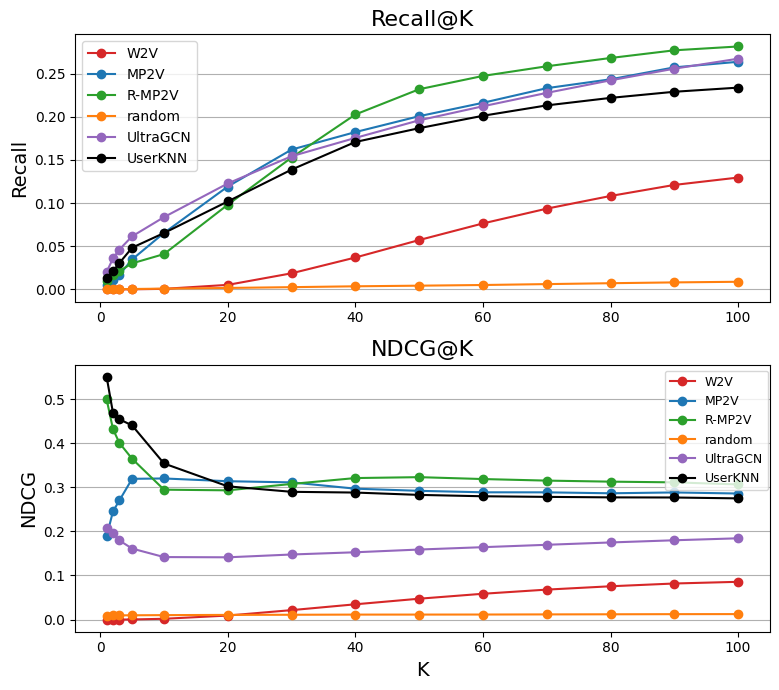

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the results from the CSV file
root = 'results/KuaiRec/'
df = pd.read_csv(root + 'results.csv', index_col=0)  # Ensure the first column is treated as index

# Test metrics for UserKNN model
userknn_metrics = {
    'Recall@1': 0.0131, 'Recall@2': 0.0212, 'Recall@3': 0.0305, 'Recall@5': 0.0483, 'Recall@10': 0.0653,
    'Recall@20': 0.1019, 'Recall@30': 0.1388, 'Recall@40': 0.1708, 'Recall@50': 0.1868, 'Recall@60': 0.2012,
    'Recall@70': 0.2132, 'Recall@80': 0.2219, 'Recall@90': 0.2290, 'Recall@100': 0.2338,
    'NDCG@1': 0.5507, 'NDCG@2': 0.4687, 'NDCG@3': 0.4542, 'NDCG@5': 0.4402, 'NDCG@10': 0.3539,
    'NDCG@20': 0.3021, 'NDCG@30': 0.2897, 'NDCG@40': 0.2880, 'NDCG@50': 0.2827, 'NDCG@60': 0.2796,
    'NDCG@70': 0.2782, 'NDCG@80': 0.2771, 'NDCG@90': 0.2768, 'NDCG@100': 0.2748
}

# Convert to DataFrame and add UserKNN model
userknn_df = pd.DataFrame.from_dict(userknn_metrics, orient='index', columns=['UserKNN'])
df = df.join(userknn_df, how='outer')  # Add the UserKNN model results

# Extract k values (removing "Recall@" prefix)
k_values = sorted([int(k.split('@')[1]) for k in df.index if k.startswith("Recall@")])

# Initialize the figure
fig, axs = plt.subplots(2, 1, figsize=(8, 7), sharex=False)
colors = {'W2V': 'tab:red', 'MP2V': 'tab:blue', 'R-MP2V': 'tab:green', 'random': 'tab:orange', 'UltraGCN': 'tab:purple', 'UserKNN': 'black'}

# Plot Recall@K
for model_name in df.columns:
    if model_name in colors.keys():
        recall_scores = df.loc[[f"Recall@{k}" for k in k_values], model_name].values
        axs[0].plot(k_values, recall_scores, marker='o', label=model_name, color=colors[model_name])
axs[0].set_title("Recall@K", fontsize=16)
axs[0].set_ylabel("Recall", fontsize=14)
axs[0].legend(fontsize=10, loc='best')  # Slightly smaller font
axs[0].grid(True, axis='y')

# Plot NDCG@K
for model_name in df.columns:
    if model_name in colors.keys():
        ndcg_scores = df.loc[[f"NDCG@{k}" for k in k_values], model_name].values
        axs[1].plot(k_values, ndcg_scores, marker='o', label=model_name, color=colors[model_name])
axs[1].set_title("NDCG@K", fontsize=16)
axs[1].set_xlabel("K", fontsize=14)
axs[1].set_ylabel("NDCG", fontsize=14)

# Adjust legend for better visibility
axs[1].legend(fontsize=9, loc='upper left', bbox_to_anchor=(0.84, 1))  # Move outside the plot
axs[1].grid(True, axis='y')

plt.tight_layout()
fig.savefig(root + "metrics_by_k.png", bbox_inches='tight')  # Ensure the legend is included
plt.show()

In [20]:
print(test_metrics_w2v)
print()
print(test_metrics_mp2v)
print()
print(test_metrics_wmp2v)

{'Recall@1': 0.0, 'Recall@2': 0.0, 'Recall@3': 0.0, 'Recall@5': 1.8801951875332403e-05, 'Recall@10': 0.0005023965759748343, 'Recall@20': 0.005010031808959945, 'Recall@30': 0.01884598825702062, 'Recall@40': 0.0372029244120687, 'Recall@50': 0.05891678066444808, 'Recall@60': 0.07729430794008786, 'Recall@70': 0.0930903156597955, 'Recall@80': 0.10774974769902435, 'Recall@90': 0.12014183046908938, 'Recall@100': 0.12958532979376358, 'NDCG@1': 0.0, 'NDCG@2': 0.0, 'NDCG@3': 0.0, 'NDCG@5': 0.00019650845312193355, 'NDCG@10': 0.001746099620072774, 'NDCG@20': 0.00872277488456467, 'NDCG@30': 0.022346782213634488, 'NDCG@40': 0.0355701442629648, 'NDCG@50': 0.04931966641737522, 'NDCG@60': 0.05986732680872784, 'NDCG@70': 0.0684163017310709, 'NDCG@80': 0.07589797192674871, 'NDCG@90': 0.08192642623034299, 'NDCG@100': 0.08605474377277124}

{'Recall@1': 0.008163112863449605, 'Recall@2': 0.019540385976441796, 'Recall@3': 0.030391328540442415, 'Recall@5': 0.04136438714540932, 'Recall@10': 0.07799125190507375,

### Visualization

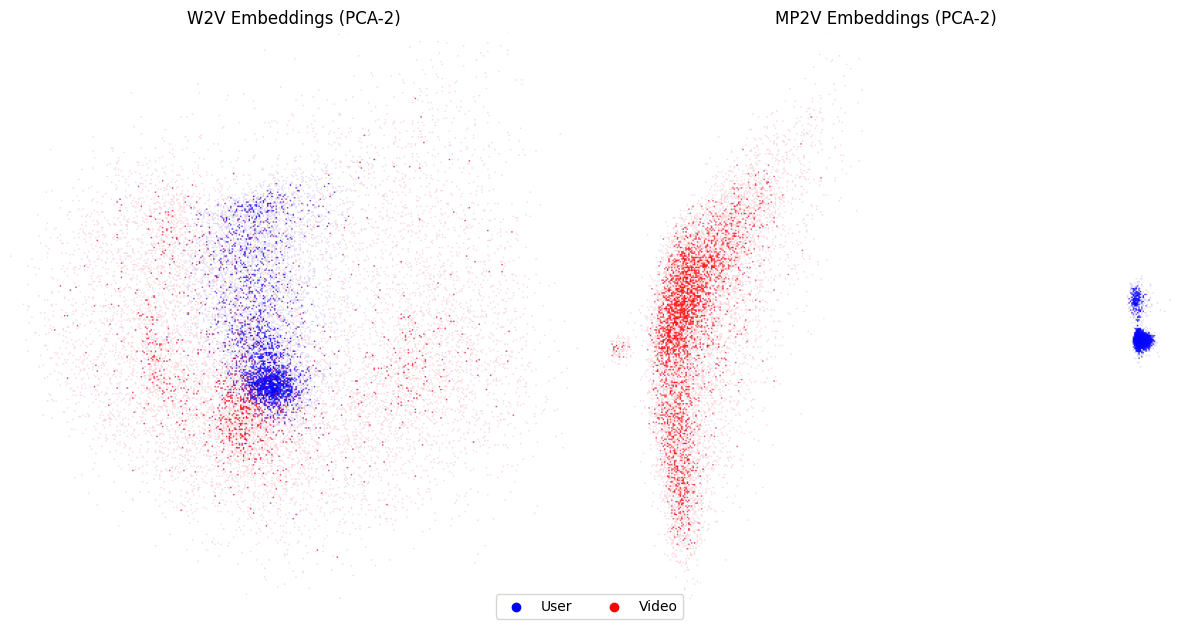

In [16]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import datashader as ds
import datashader.transfer_functions as tf
import matplotlib.pyplot as plt

# Load W2V embeddings
w2v_user_emb = np.load("runs/KuaiRec/w2v_user_emb.npy")
w2v_video_emb = np.load("runs/KuaiRec/w2v_video_emb.npy")

# Load MP2V embeddings
mp2v_user_emb = np.load("runs/KuaiRec/mp2v_user_emb.npy")
mp2v_video_emb = np.load("runs/KuaiRec/mp2v_video_emb.npy")

# Stack users & videos together
w2v_combined = np.vstack((w2v_user_emb, w2v_video_emb))
mp2v_combined = np.vstack((mp2v_user_emb, mp2v_video_emb))

# PCA transformation
pca = PCA(n_components=2, random_state=42)
w2v_2d = pca.fit_transform(w2v_combined)
mp2v_2d = pca.fit_transform(mp2v_combined)

# Split back into users & videos
n_users = w2v_user_emb.shape[0]
w2v_user_2d, w2v_video_2d = w2v_2d[:n_users], w2v_2d[n_users:]
mp2v_user_2d, mp2v_video_2d = mp2v_2d[:n_users], mp2v_2d[n_users:]

# Create DataFrames
w2v_df = pd.DataFrame(np.vstack((w2v_user_2d, w2v_video_2d)), columns=['x', 'y'])
w2v_df['type'] = pd.Categorical(['user'] * n_users + ['video'] * (len(w2v_df) - n_users))

mp2v_df = pd.DataFrame(np.vstack((mp2v_user_2d, mp2v_video_2d)), columns=['x', 'y'])
mp2v_df['type'] = pd.Categorical(['user'] * n_users + ['video'] * (len(mp2v_df) - n_users))

# Compute x/y bounds for both datasets
x_bounds_w2v = [np.percentile(w2v_df['x'], 0.5), np.percentile(w2v_df['x'], 99.5)]
y_bounds_w2v = [np.percentile(w2v_df['y'], 0.5), np.percentile(w2v_df['y'], 99.5)]

x_bounds_mp2v = [np.percentile(mp2v_df['x'], 0.5), np.percentile(mp2v_df['x'], 99.5)]
y_bounds_mp2v = [np.percentile(mp2v_df['y'], 0.5), np.percentile(mp2v_df['y'], 99.5)]

# Datashader Canvas
canvas = ds.Canvas(plot_width=400, plot_height=400)

# Aggregate W2V
agg_w2v = canvas.points(w2v_df, 'x', 'y', ds.count_cat('type'))
img_w2v = tf.shade(agg_w2v, color_key={'user': 'blue', 'video': 'red'})

# Aggregate MP2V
agg_mp2v = canvas.points(mp2v_df, 'x', 'y', ds.count_cat('type'))
img_mp2v = tf.shade(agg_mp2v, color_key={'user': 'blue', 'video': 'red'})

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# W2V Plot
ax1.imshow(img_w2v.to_pil())
ax1.set_title("W2V Embeddings (PCA-2)")
ax1.axis("off")

# MP2V Plot
ax2.imshow(img_mp2v.to_pil())
ax2.set_title("MP2V Embeddings (PCA-2)")
ax2.axis("off")

# Add legend
user_proxy = plt.scatter([], [], c="blue", label="User")
video_proxy = plt.scatter([], [], c="red", label="Video")

fig.legend(handles=[user_proxy, video_proxy], loc="lower center", ncol=2, bbox_to_anchor=(0.5, -0.02))

plt.tight_layout()
plt.savefig("results/KuaiRec/pca_embeddings.png")
plt.show()